# RankNet

This is the generic implementation of RankNet on a synthetic dataset.

This model is applied to hotel imags in the other notebook.

![alt text](assets/siamese-net.png "Title")

In [1]:
import numpy as np

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Input, Lambda, Dropout, Subtract
from keras.models import Model, Sequential
from keras.utils import plot_model
%pylab inline

INPUT_DIM = 1536

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Base Network

This is a scoring function (regression) that takes an images vector as input and outputs a scalar number. The Siamese model create two of these base networks to for higher and lower ranking images respectively.

In [2]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(INPUT_DIM, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(1))
    return seq

## Siamse Archecture

We create two instances of the base archecture and take the difference between their scalar outputs. We then pass the difference between a sigmoid function so that we can use binary-cross-entropy for the differntiable loss function.

In [3]:
def create_meta_network(input_dim, base_network):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    rel_score = base_network(input_a)
    irr_score = base_network(input_b)

    # subtract scores
    diff = Subtract()([rel_score, irr_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid")(diff)

    # Build model.
    model = Model(inputs = [input_a, input_b], outputs = prob)
    model.compile(optimizer = "adam", loss = "binary_crossentropy")

    return model

In [7]:
base_network = create_base_network(INPUT_DIM)
model = create_meta_network(INPUT_DIM, base_network)
model.summary()

plot_model(base_network, to_file='base.png')
plot_model(model, to_file='meta.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            2461313     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
subtract_4 (Subtract)           (None, 1)            0           sequential_4[1][0]               
          

### Base Network

This can be any (scoring) function which outputs a scalar:
![base](base.png)

### Meta Network

This takes an instance of the base network and evalutes the pair on it:
![meta](meta.png)

## Synthetic Dataset

We generate two N dimensional datasets from an uniform distribution where one distribution is shift by a constant. This can be thought of as a good image and a less good image that we want to learn to differentiate.

In [28]:
# Fake data.
N = 1000
SPLIT=750
X_1 = 2* np.random.randn(N, INPUT_DIM) # notice this data is shifted by 2
X_2 = np.random.randn(N, INPUT_DIM)

X_1_train = X_1[0:SPLIT,:]
X_1_test = X_1[SPLIT:N,:]

X_2_train = X_2[0:SPLIT,:]
X_2_test =  X_2[SPLIT:N,:]


y = np.ones((X_1.shape[0], 1))

y_train = y[0:SPLIT,:]
y_test = y[SPLIT:N,:]

np.mean(X_1_train), np.mean(X_2_train)

(0.0023731553517547066, -0.00052067296140614276)

In [29]:
# Train model.

es=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

NUM_EPOCHS = 10
BATCH_SIZE = 10
history = model.fit([X_1_train, X_2_train], y_train, 
                    validation_data=([X_1_test, X_2_test], y_test), 
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1, callbacks=[es])

Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 7s 9ms/step - loss: 0.0460 - val_loss: 1.1323e-04
Epoch 2/10
750/750 [==============================] - 5s 7ms/step - loss: 0.0045 - val_loss: 3.0593e-04
Epoch 3/10
750/750 [==============================] - 6s 8ms/step - loss: 8.4689e-04 - val_loss: 8.8093e-04
Epoch 00003: early stopping


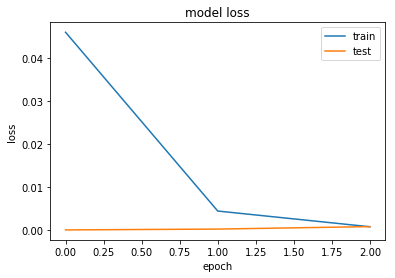

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [31]:
#the mean score of the high-rank distribution should be higher
np.mean(base_network.predict(X_1_test)), np.mean(base_network.predict(X_2_test))

(46.19725, 22.895014)

In [32]:
#AUC
(np.sum(base_network.predict(X_1_test) > base_network.predict(X_2_test))+0.0) / X_1_test.shape[0]

1.0